In [8]:
import numpy as np
# from gurobipy import *
import pandas as pd
import csv

## Sets & Parameters

In [9]:
# segments
segment = np.arange(1, 11)

# Yards 
yards = ["R", "M", "W", "D", "E", "P", "S"]

# Train type
consist = [5, 10]

# Shifts 
shifts = np.arange(240, 1441, 120)

# Segment Yard Relation 
segment_departureYard = {1 : "R", 
                        2 : "M", 
                        3 : "R", 
                        4 : "W", 
                        5 : "D", 
                        6 : "E", 
                        7 : "P", 
                        8 : "S", 
                        9 : "D", 
                        10 : "W"}

segment_arrivalYard = {1 : "M", 
                        2 : "R", 
                        3 : "W", 
                        4 : "R", 
                        5 : "E", 
                        6 : "D", 
                        7 : "S", 
                        8 : "P", 
                        9 : "W", 
                        10 : "D"}


yard_num = np.arange(7)
yards_number = dict(zip(yards, yard_num))


In [10]:
distance = [37.09, 37.09, 41.37, 41.37, 39.64, 39.64, 52.81, 52.81, 44.14, 44.14]
time = [72.5, 72.5, 72.45, 72.45, 71.5, 71.5, 73, 73, 74.95, 74.95]
    
    
segment_travelTime = dict(zip(segment, time))
segment_distance = dict(zip(segment, distance))

In [11]:
a = pd.read_pickle("alpha.pkl")
b = pd.read_pickle("beta.pkl")

# Load Alpha Set
k = a[["Travel Segment (a)", "Departure Index (c)"]].values
a_keys = []
for x in k:
    a_keys.append((x[0], x[1]))
a_values = a["Time of Departure (alpha)"].values
alpha = dict(zip(a_keys, a_values))

# Load Beta Set
k = b[["Travel Segment (a)", "Departure Index (c)"]].values
b_keys = []
for x in k:
    b_keys.append((x[0], x[1]))
b_values = b["Time of Arrival (beta)"].values
beta = dict(zip(b_keys, b_values))


In [12]:
# Load in interval relation  data 
interval_relation = pd.read_csv('preprocessing_data/intervals - intervals.csv')

temp = interval_relation[["a", "zi", "c"]].values
keys = []
for x in temp:
    keys.append((x[0], x[1], x[2]))
values = interval_relation["Fac"].values

interval_fac = dict(zip(keys, values))



In [13]:
interval_relation.head()

,Unnamed: 0,zi,Fac,a,c
0,0,240,1.0,1,1
1,1,240,0.8,1,2
2,2,240,0.6,1,3
3,3,240,0.4,1,4
4,4,240,0.2,1,5


In [14]:
# for zi and a give array of c
zi_dict = {}
for index, row in interval_relation.iterrows():
    zi_dict[(row.zi, row.a)] = []
    
for index, row in interval_relation.iterrows():
    temp = zi_dict[(row.zi, row.a)]
    temp.append(row.c)
    zi_dict[(row.zi, row.a)] = temp


In [15]:
# Load in Passenger Demand. 24 Hour
p = pd.read_csv('preprocessing_data/passenger_flow - passenger_flow.csv')
p = p.drop(columns=["Unnamed: 0"])

temp = p[["a", "hour"]].values
keys = []
for x in temp:
    keys.append((x[0], x[1]))
values = p["no. of passengers"].values
seg_interval_demand = dict(zip(keys, values))


In [16]:
# Load in yard event index data 
yardEvent = pd.read_csv('preprocessing_data/all_yards_indexes - all_yards_indexes.csv')
yardEvent.head()

yardEvent.loc[yardEvent['Type'] == 'D', 'Type'] = -1
yardEvent.loc[yardEvent['Type'] == 'A', 'Type'] = 1


In [17]:
c = yardEvent.iloc[:, 1:3]

# max departure index for each segment (decision variable helper)
list_s_max = []
for s in segment:
    index_segment_set = c.where(c.a == s).dropna()
    s_index_max = np.max(index_segment_set.c.values)
    list_s_max.append(int(s_index_max))
    
list_s_max

departure_segment_max = dict(zip(segment, list_s_max))
departure_segment_max

{1: 78, 2: 78, 3: 96, 4: 96, 5: 99, 6: 99, 7: 109, 8: 109, 9: 86, 10: 86}

In [18]:
# max yard event index for each yard 
# ye = pd.read_pickle("yardEvents.pkl")

list_y_max = []
for y in yards:
    index_y_set = yardEvent.where(yardEvent.Yard == y).dropna()
    y_index_max = np.max(index_y_set.yardEventIndex.values)
    list_y_max.append(int(y_index_max))
    
list_y_max

event_yard_max = dict(zip(yards, list_y_max))


In [19]:
# Get mapping from yard + event index to event type

temp = yardEvent[["Yard", "yardEventIndex"]].values
keys = []
for x in temp:
    keys.append((x[0], x[1]))
values = yardEvent["Type"].values
yard_event_Type = dict(zip(keys, values))

In [20]:
# Given yard, event index give segment
temp = yardEvent[["Yard", "yardEventIndex"]].values
keys = []
for x in temp:
    keys.append((x[0], x[1]))
values = yardEvent["a"].values
yard_event_Segment = dict(zip(keys, values))


In [21]:
# Given yard, event index give departure index 
temp = yardEvent[["Yard", "yardEventIndex"]].values
keys = []
for x in temp:
    keys.append((x[0], x[1]))
values = yardEvent["c"].values
yard_event_Index = dict(zip(keys, values))

In [22]:
# Load in yard_shift_index
yard_shift_index_relation = pd.read_csv('preprocessing_data/Yard_Shift_Index - Yard_Shift_Index.csv')
yard_shift_index_relation.head()

yard_shift_index_relation.drop(columns=["Unnamed: 0", "a", "c", "Type", "Time"], inplace=True)


In [23]:
# for zi and a give array of c
shift_event_dict = {}
for index, row in yard_shift_index_relation.iterrows():
    shift_event_dict[(row.Yard, row.Shift)] = []
    
for index, row in yard_shift_index_relation.iterrows():
    temp = shift_event_dict[(row.Yard, row.Shift)]
    temp.append(row.j)
    shift_event_dict[(row.Yard, row.Shift)] = temp

In [17]:
# Load in am_peak, Load in pm_peak 
am_peak = pd.read_csv("preprocessing_data/am_peak - am_peak.csv")
pm_peak = pd.read_csv("preprocessing_data/pm_peak - pm_peak.csv")
peak_rides = pd.concat([am_peak, pm_peak])
keys = np.arange(peak_rides.size)

peak_data = []
temp = peak_rides[["Travel Segment (a)", "Departure Index (c)"]].values
for x in temp:
    peak_data.append((x[0], x[1]))

# peak_segments = peak_rides["Travel Segment (a)"].values
# peak_departures = peak_rides["Departure Index (c)"].values

peak_departure_segment_relation = dict(zip(keys, peak_data))
# peak_departure_segment_relation

### Costs 

In [18]:
# cost of running a 5-car consist [wear & tear + electricity]/car-mile
cost_running = 8.96744729

# 9
# 8.96744729

# cost/ team per shift
cost_shiftTeam = 198

# cost make/break
cost_makebreak = 36.63161448
# 37
# 36.63161448


### Other

In [19]:
carrying_capacity_5 = 575

## Decision Variables 

In [20]:
# Create a new model
model = Model('steady state fleet')

Academic license - for non-commercial use only


In [21]:
# Binary Variable. Type of train from travel segment a, at index c. 1 index
# Booleans to signify if traing segment node should depart with big train. Big = 10 car, Other = 5 car
ts_1 = model.addVars(np.arange(1, departure_segment_max.get(1) + 1), vtype=GRB.BINARY, name="TS1")
ts_2 = model.addVars(np.arange(1, departure_segment_max.get(2) + 1), vtype=GRB.BINARY, name="TS2")
ts_3 = model.addVars(np.arange(1, departure_segment_max.get(3) + 1), vtype=GRB.BINARY, name="TS3")
ts_4 = model.addVars(np.arange(1, departure_segment_max.get(4) + 1), vtype=GRB.BINARY, name="TS4")
ts_5 = model.addVars(np.arange(1, departure_segment_max.get(5) + 1), vtype=GRB.BINARY, name="TS5")
ts_6 = model.addVars(np.arange(1, departure_segment_max.get(6) + 1), vtype=GRB.BINARY, name="TS6")
ts_7 = model.addVars(np.arange(1, departure_segment_max.get(7) + 1), vtype=GRB.BINARY, name="TS7")
ts_8 = model.addVars(np.arange(1, departure_segment_max.get(8) + 1), vtype=GRB.BINARY, name="TS8")
ts_9 = model.addVars(np.arange(1, departure_segment_max.get(9) + 1), vtype=GRB.BINARY, name="TS9")
ts_10 = model.addVars(np.arange(1, departure_segment_max.get(10) + 1), vtype=GRB.BINARY, name="TS10")

segmentTrain = [ts_1, ts_2, ts_3, ts_4, ts_5, ts_6, ts_7, ts_8, ts_9, ts_10]



In [22]:
# Set Variable. Level of staff needed at yard y and shift s
# currrently not used in constraint
levelStaff = model.addVars(yards, shifts, lb = 0.0, vtype=GRB.SEMIINT, name="levelStaff")


In [23]:
# Auxiliary Variable. DV. Currently using filler upper bound. 
# Capacity of each Train Segment Node
iy_R = model.addVars(consist, np.arange(event_yard_max.get("R") + 1), lb = 0.0, ub = 227, name="IYR")
iy_M = model.addVars(consist, np.arange(event_yard_max.get("M") + 1), lb = 0.0, ub = 62, name="IYM")
iy_W = model.addVars(consist, np.arange(event_yard_max.get("W") + 1), lb = 0.0, ub = 333, name="IYW")
iy_D = model.addVars(consist, np.arange(event_yard_max.get("D") + 1), lb = 0.0, ub = 169, name="IYD")
iy_E = model.addVars(consist, np.arange(event_yard_max.get("E") + 1), lb = 0.0, ub = 70, name="IYE")
iy_P = model.addVars(consist, np.arange(event_yard_max.get("P") + 1), lb = 0.0, ub = 314, name="IYP")
iy_S = model.addVars(consist, np.arange(event_yard_max.get("S") + 1), lb = 0.0, ub = 45, name="IYS")




inventoryYard = [iy_R, iy_M, iy_W, iy_D, iy_E, iy_P, iy_S]

iY_dict = dict(zip(yards, inventoryYard))

In [24]:
# Make Binary DV. For each yard, for each yard event 
# 
M_R = model.addVars(np.arange(event_yard_max.get("R") + 1), vtype=GRB.BINARY, name="M_R")
M_M = model.addVars(np.arange(event_yard_max.get("M") + 1), vtype=GRB.BINARY, name="M_M")
M_W = model.addVars(np.arange(event_yard_max.get("W") + 1), vtype=GRB.BINARY, name="M_W")
M_D = model.addVars(np.arange(event_yard_max.get("D") + 1), vtype=GRB.BINARY, name="M_D")
M_E = model.addVars(np.arange(event_yard_max.get("E") + 1), vtype=GRB.BINARY, name="M_E")
M_P = model.addVars(np.arange(event_yard_max.get("P") + 1), vtype=GRB.BINARY, name="M_P")
M_S = model.addVars(np.arange(event_yard_max.get("S") + 1), vtype=GRB.BINARY, name="M_S")

makes = [M_R, M_M, M_W, M_D, M_E, M_P, M_S]

makes_dict = dict(zip(yards, makes))


In [25]:
# Break Binary DV. For each yard, for each yard event # Make Binary DV. For each yard, for each yard event 
B_R = model.addVars(np.arange(event_yard_max.get("R") + 1), vtype=GRB.BINARY, name="B_R")
B_M = model.addVars(np.arange(event_yard_max.get("M") + 1), vtype=GRB.BINARY, name="B_M")
B_W = model.addVars(np.arange(event_yard_max.get("W") + 1), vtype=GRB.BINARY, name="B_W")
B_D = model.addVars(np.arange(event_yard_max.get("D") + 1), vtype=GRB.BINARY, name="B_D")
B_E = model.addVars(np.arange(event_yard_max.get("E") + 1), vtype=GRB.BINARY, name="B_E")
B_P = model.addVars(np.arange(event_yard_max.get("P") + 1), vtype=GRB.BINARY, name="B_P")
B_S = model.addVars(np.arange(event_yard_max.get("S") + 1), vtype=GRB.BINARY, name="B_S")

breaks = [B_R, B_M, B_W, B_D, B_E, B_P, B_S]

breaks_dict = dict(zip(yards, breaks))

In [26]:
model.update()

## Objective Function 

In [27]:
obj = ( # C * sum over all segments, all departureIndexes 
        cost_running * sum((1 + segmentTrain[(seg-1)].get(d_index)) *  segment_distance.get(seg)
                            for seg, d_index in [(seg, d_index) 
                                for seg in segment 
                                for d_index in np.arange(1, departure_segment_max.get(seg) + 1)])
    
      + # C * shift level 
        cost_shiftTeam * sum(levelStaff.get((y, s)) 
                            for y, s in [(y, s) for y in yards for s in shifts])
    
      + # C * number of makes / breaks
        cost_makebreak * sum(makes[yards_number.get(y)].get(event_index) 
                             + breaks[yards_number.get(y)].get(event_index) 
                                for y, event_index in [(y, event_index)
                                    for y in yards
                                    for event_index in np.arange(event_yard_max.get(y) + 1)])  
)

In [28]:
model.setObjective(obj, GRB.MINIMIZE)

## Constraints 

In [29]:
constraints = []

#### Passenger Demand AM Peak, PM Peak PreProcessing

In [30]:
for keys, values in peak_departure_segment_relation.items():
    constraints.append(segmentTrain[values[0] - 1].get(values[1]) == 1)
    model.addConstr(segmentTrain[values[0] - 1].get(values[1]) == 1)
    

#### Passenger Demand
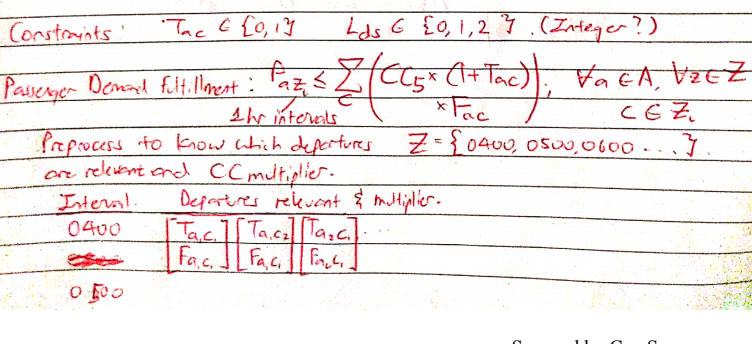

In [31]:
# constraints = []


train_size_decision_by_segment_and_departure_time = segmentTrain

def carry_capacity(segment, time):
    is_big_train = train_size_decision_by_segment_and_departure_time[segment - 1].get(time)
    return (1 + is_big_train) * carrying_capacity_5


# THE ONE THAT RUNS BUT IS INFEASIBLE 
for train_segment in segment:
    for time_of_day_in_min in np.arange(240, 1441, 60):

        departure_times_from_start_in_next_hour = zi_dict.get((time_of_day_in_min, train_segment))
        estimated_max_ppl_along_route = seg_interval_demand.get((train_segment, time_of_day_in_min)) * 1.32 # Factor higher

        if departure_times_from_start_in_next_hour is None or len(departure_times_from_start_in_next_hour) == 0:
            continue

        if estimated_max_ppl_along_route is None:
            print('missing estimation for %s %s' % (train_segment, time_of_day_in_min))
            continue

        train_support_variable = sum(carry_capacity(train_segment, time) for time in departure_times_from_start_in_next_hour)
        train_support_max = sum(carrying_capacity_5*2 for time in departure_times_from_start_in_next_hour)
        

        constraints.append(train_support_variable >= min(estimated_max_ppl_along_route, train_support_max))
        
# constraints

In [32]:
for c in constraints:
    model.addConstr(c)

model.update()
model.optimize()

Optimize a model with 526 rows, 8501 columns and 1584 nonzeros
Variable types: 3744 continuous, 4680 integer (4680 binary)
Semi-Variable types: 0 continuous, 77 integer
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [4e+01, 5e+02]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e+00, 7e+03]
Found heuristic solution: objective 443301.54208
Presolve removed 526 rows and 8501 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 442969 443302 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.429689394609e+05, best bound 4.429689394609e+05, gap 0.0000%


#### Car Inventory 
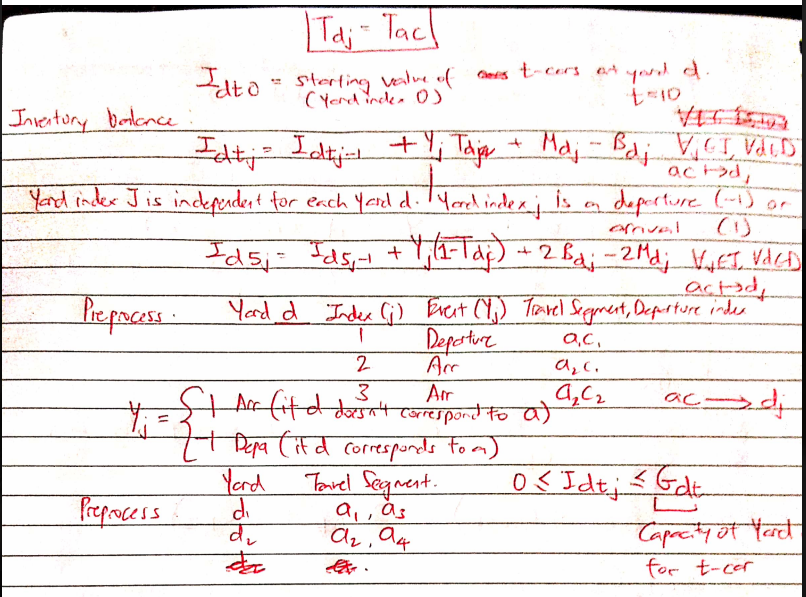

In [33]:
# Inventory balance for 10 car trains 
for y in yards:
   
    model.addConstrs(iY_dict.get(y).get((10, event_index)) == iY_dict.get(y).get((10, event_index - 1))
                                                 + yard_event_Type.get((y, event_index)) 
                                                 * segmentTrain[yard_event_Segment.get((y, event_index)) - 1].get(yard_event_Index.get((y, event_index)))
                                                 + makes_dict.get(y).get(event_index)
                                                 - breaks_dict.get(y).get(event_index)
                                                        for event_index in np.arange(1, event_yard_max.get(y) + 1))

    

In [34]:
# Inventory balance for 5 car trains 
for y in yards:
    
    model.addConstrs(iY_dict.get(y).get((5, event_index)) == iY_dict.get(y).get((5, event_index - 1))
                                                 + yard_event_Type.get((y, event_index)) 
                                                 * segmentTrain[yard_event_Segment.get((y, event_index)) - 1].get(yard_event_Index.get((y, event_index)))
                                                 - 2 * makes_dict.get(y).get(event_index)
                                                 + 2 *breaks_dict.get(y).get(event_index)
                                                        for event_index in np.arange(1, event_yard_max.get(y) + 1))


In [35]:
# model.update()
# model.optimize()

#### Start State, End State Inventory 
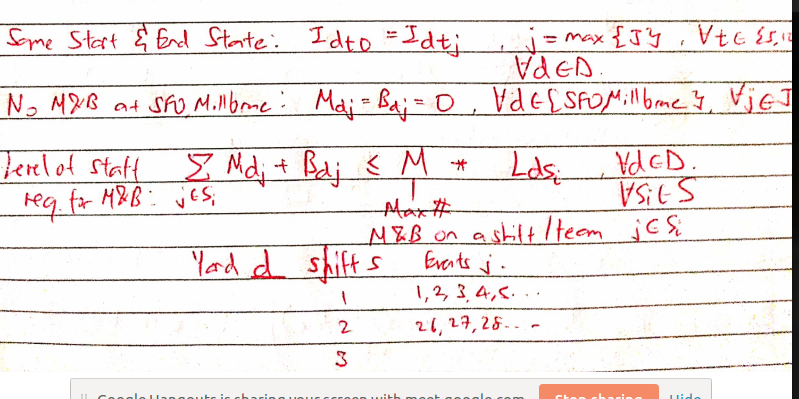

In [36]:
train_yard = np.array([203, 56, 298, 151, 63, 282, 27])
initial_trains_at_yards = dict(zip(yards, train_yard))
initial_trains_at_yards

train_yard_10 = np.array([160, 40, 280, 120, 60, 210, 30]) # Full Cars 
# train_yard_10 = np.array([130, 30, 220, 100, 50, 170, 30]) # With 20% Spare Ratio Accounted for (So 80% of total train in use)
# train_yard_10 = np.array([65, 15, 110, 50, 25, 85, 13]) # 50% 
# train_yard_10 = np.array([210, 50, 300, 100, 110, 280, 30]) # Full Cars In Force. All 10 Car Unbreakable 
initial_10car_trains_at_yards = dict(zip(yards, train_yard_10))


train_yard_5 = np.array([45, 15, 20, 30, 0, 70, 0]) # Full Cars 
# train_yard_5 = np.array([35, 10, 15, 25, 0, 55, 0])  # # With 20% Spare Ratio Accounted for (So 80% of total train in use)
# train_yard_5 = np.array([17, 5, 8, 13, 0, 28, 0]) # 50% 
# train_yard_5 = np.array([0, 0, 0, 0, 0, 0, 0]) # No 5 car if all 10 unbreakable 
initial_5car_trains_at_yards = dict(zip(yards, train_yard_5))



In [37]:
# Initialize number of train cars that start at each yard 
for y in yards:
    constraints.append((iY_dict.get(y).get((5, 0))) == initial_5car_trains_at_yards.get(y))
    constraints.append((iY_dict.get(y).get((10, 0))) == initial_10car_trains_at_yards.get(y))
    
    model.addConstr((iY_dict.get(y).get((5, 0))) == initial_5car_trains_at_yards.get(y))
    model.addConstr((iY_dict.get(y).get((10, 0))) == initial_10car_trains_at_yards.get(y))


#     model.addConstr((iY_dict.get(y).get((5, 0)) + iY_dict.get(y).get((10, 0))) == initial_trains_at_yards.get(y))
     

In [38]:
# Inventory at first event must be equal to the inventory of its last event at the end of the day. 
for y in yards:
    for tL in consist:
        constraints.append(iY_dict.get(y).get((tL, 0)) == iY_dict.get(y).get((tL, event_yard_max.get(y))))
        model.addConstr(iY_dict.get(y).get((tL, 0)) == iY_dict.get(y).get((tL, event_yard_max.get(y))))
        

        

In [39]:
# model.update()
# model.optimize()

#### No Making/Breaking at SFO or WarmSprings

In [40]:
for y in ["S", "W"]:
    model.addConstrs(makes_dict.get(y).get(event_index) == 0 for event_index in np.arange(event_yard_max.get(y) + 1) )


for y in ["S", "W"]:
    model.addConstrs(breaks_dict.get(y).get(event_index) == 0 for event_index in np.arange(event_yard_max.get(y) + 1))

#### Level of Staff Constraint

In [41]:
level_constraints = []

for y in yards:
    for s in shifts:
        events_from_start_shift_next_two_hours = shift_event_dict.get((y, s))
        levelStaff_at_shift = levelStaff.get((y, s))

        
        if events_from_start_shift_next_two_hours is None or len(events_from_start_shift_next_two_hours) == 0:
            continue
            
        if levelStaff_at_shift is None:
            continue
        
        number_makes_breaks_in_shift = sum(makes_dict.get(y).get(event_index) + breaks_dict.get(y).get(event_index) for event_index in events_from_start_shift_next_two_hours)
        constraints.append(levelStaff_at_shift * 15 >= number_makes_breaks_in_shift)
        level_constraints.append(levelStaff_at_shift * 15 >= number_makes_breaks_in_shift)
        
for lc in level_constraints:
    model.addConstr(lc)

## Solve & Analysis

In [42]:
model.update()
model.Params.outputFlag = 1
model.optimize()


Parameter outputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Optimize a model with 5523 rows, 8501 columns and 25259 nonzeros
Variable types: 3744 continuous, 4680 integer (4680 binary)
Semi-Variable types: 0 continuous, 77 integer
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [4e+01, 5e+02]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e+00, 7e+03]

MIP start did not produce a new incumbent solution

Presolve removed 3665 rows and 4093 columns
Presolve time: 0.11s
Presolved: 1858 rows, 4408 columns, 11882 nonzeros
Variable types: 0 continuous, 4408 integer (2547 binary)

Root relaxation: objective 4.564336e+05, 421 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 456433.607    0   29          - 456433.607      -     -    0s
     0     0 456433.607    0   91          - 456433.607      -     -    0s

## Calculate Cost of BaseLine Strategy 

In [43]:
cost_running_base_strategy = ( # C * sum over all segments, all departureIndexes 
        cost_running * sum((1 + segmentTrain[(seg-1)].get(d_index).x) *  segment_distance.get(seg)
                            for seg, d_index in [(seg, d_index) 
                                for seg in segment 
                                for d_index in np.arange(1, departure_segment_max.get(seg) + 1)])
    
      + # C * shift level 
        cost_shiftTeam * sum(levelStaff.get((y, s)).x 
                            for y, s in [(y, s) for y in yards for s in shifts])
    
      + # C * number of makes / breaks
        cost_makebreak * sum(makes[yards_number.get(y)].get(event_index).x 
                             + breaks[yards_number.get(y)].get(event_index).x 
                                for y, event_index in [(y, event_index)
                                    for y in yards
                                    for event_index in np.arange(event_yard_max.get(y) + 1)]))

In [44]:
cost_operational_base = ( # C * sum over all segments, all departureIndexes 
        cost_running * sum((1 + segmentTrain[(seg-1)].get(d_index).x) *  segment_distance.get(seg)
                            for seg, d_index in [(seg, d_index) 
                                for seg in segment 
                                for d_index in np.arange(1, departure_segment_max.get(seg) + 1)])
)

In [45]:
cost_level_shift_base = (# C * shift level 
        cost_shiftTeam * sum(levelStaff.get((y, s)).x 
                            for y, s in [(y, s) for y in yards for s in shifts])
    
)

In [46]:
cost_makebreak_base =  ( # C * number of makes / breaks
        cost_makebreak * sum(makes[yards_number.get(y)].get(event_index).x 
                             + breaks[yards_number.get(y)].get(event_index).x 
                                for y, event_index in [(y, event_index)
                                    for y in yards
                                    for event_index in np.arange(event_yard_max.get(y) + 1)]))

In [47]:
print("Base Total Cost: " + str(cost_running_base_strategy))
print("Base Op Cost / Mile: " + str(cost_operational_base))
print("Base Shift Team Cost: " + str(cost_level_shift_base))
print("Base Cost All M/B: " + str(cost_makebreak_base))

print("Starting 10 Car Train Inventory: ",  train_yard_10)
print("Starting 5 Car Train Inventory: ", train_yard_5)

print("Cost Running: " + str(cost_running))
print("Cost Shift Team: " + str(cost_shiftTeam))
print("Cost Make Break: " + str(cost_makebreak))

    

Base Total Cost: 456592.00655
Base Op Cost / Mile: 455536.637489
Base Shift Team Cost: 396.0
Base Cost All M/B: 659.36906064
('Starting 10 Car Train Inventory: ', array([160,  40, 280, 120,  60, 210,  30]))
('Starting 5 Car Train Inventory: ', array([45, 15, 20, 30,  0, 70,  0]))
Cost Running: 8.96744729
Cost Shift Team: 198
Cost Make Break: 36.63161448


# Interpret Results & Export Results

In [48]:
# for v in model.getVars():
#     print(v.varName, v.x)

In [49]:
# var_names = []    

# for var in model.getVars():
#     var_names.append((var.VarName, var.x))

# # Write to csv
# with open('baseline.csv', 'wb') as myfile:
#      wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#      wr.writerows(var_names)

## Exporting Results For Easier Analysis 

### TrainSegment Decision Variables to CSV 



#### Export as pickle

In [50]:
# # For TS1 
# seg = 1 
# keys = []
# values = []
# for i in np.arange(1, departure_segment_max.get(seg)):
#     values.append(int(segmentTrain[seg-1].get(i).x))
#     key_name =  i
#     keys.append(key_name)
    
# ts_1_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
# ts_1_values.sort_index()
# ts_1_values.to_pickle("baseline_dv/ts_1_values.pkl")


# # For TS2
# seg = 2
# keys = []
# values = []
# for i in np.arange(1, departure_segment_max.get(seg)):
#     values.append(int(segmentTrain[seg-1].get(i).x))
#     key_name =  i
#     keys.append(key_name)
    
# ts_2_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
# ts_2_values.sort_index()

# ts_2_values.to_pickle("baseline_dv/ts_2_values.pkl")

# # For TS3
# seg = 3
# keys = []
# values = []
# for i in np.arange(1, departure_segment_max.get(seg)):
#     values.append(int(segmentTrain[seg-1].get(i).x))
#     key_name =  i
#     keys.append(key_name)
    
# ts_3_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
# ts_3_values.sort_index()
# ts_3_values.to_pickle("baseline_dv/ts_3_values.pkl")

# # For TS4
# seg = 4 
# keys = []
# values = []
# for i in np.arange(1, departure_segment_max.get(seg)):
#     values.append(int(segmentTrain[seg-1].get(i).x))
#     key_name =  i
#     keys.append(key_name)
    
# ts_4_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
# ts_4_values.sort_index()
# ts_4_values.to_pickle("baseline_dv/ts_4_values.pkl")

# # For TS5
# seg = 5 
# keys = []
# values = []
# for i in np.arange(1, departure_segment_max.get(seg)):
#     values.append(int(segmentTrain[seg-1].get(i).x))
#     key_name =  i
#     keys.append(key_name)
    
# ts_5_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
# ts_5_values.sort_index()
# ts_5_values.to_pickle("baseline_dv/ts_5_values.pkl")

# # For TS6
# seg = 6 
# keys = []
# values = []
# for i in np.arange(1, departure_segment_max.get(seg)):
#     values.append(int(segmentTrain[seg-1].get(i).x))
#     key_name =  i
#     keys.append(key_name)
    
# ts_6_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
# ts_6_values.sort_index()
# ts_6_values.to_pickle("baseline_dv/ts_6_values.pkl")

# # For TS7 
# seg = 7 
# keys = []
# values = []
# for i in np.arange(1, departure_segment_max.get(seg)):
#     values.append(int(segmentTrain[seg-1].get(i).x))
#     key_name =  i
#     keys.append(key_name)
    
# ts_7_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
# ts_7_values.sort_index()
# ts_7_values.to_pickle("baseline_dv/ts_7_values.pkl")

# # For TS8
# seg = 8 
# keys = []
# values = []
# for i in np.arange(1, departure_segment_max.get(seg)):
#     values.append(int(segmentTrain[seg-1].get(i).x))
#     key_name =  i
#     keys.append(key_name)
    
# ts_8_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
# ts_8_values.sort_index()
# ts_8_values.to_pickle("baseline_dv/ts_8_values.pkl")

# # For TS9
# seg = 9
# keys = []
# values = []
# for i in np.arange(1, departure_segment_max.get(seg)):
#     values.append(int(segmentTrain[seg-1].get(i).x))
#     key_name =  i
#     keys.append(key_name)
    
# ts_9_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
# ts_9_values.sort_index()
# ts_9_values.to_pickle("baseline_dv/ts_9_values.pkl")

# # For TS10
# seg = 10 
# keys = []
# values = []
# for i in np.arange(1, departure_segment_max.get(seg)):
#     values.append(int(segmentTrain[seg-1].get(i).x))
#     key_name =  i
#     keys.append(key_name)
    
# ts_10_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
# ts_10_values.sort_index()
# ts_10_values.to_pickle("baseline_dv/ts_10_values.pkl")



#### Export as CSV

In [51]:
# For TS1 
seg = 1 
keys = []
values = []
for i in np.arange(1, departure_segment_max.get(seg)):
    values.append(int(segmentTrain[seg-1].get(i).x))
    key_name =  i
    keys.append(key_name)
    
ts_1_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
ts_1_values.sort_index()
ts_1_values.to_csv("baseline_dv/ts_1_values.csv")


# For TS2
seg = 2
keys = []
values = []
for i in np.arange(1, departure_segment_max.get(seg)):
    values.append(int(segmentTrain[seg-1].get(i).x))
    key_name =  i
    keys.append(key_name)
    
ts_2_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
ts_2_values.sort_index()

ts_2_values.to_csv("baseline_dv/ts_2_values.csv")

# For TS3
seg = 3
keys = []
values = []
for i in np.arange(1, departure_segment_max.get(seg)):
    values.append(int(segmentTrain[seg-1].get(i).x))
    key_name =  i
    keys.append(key_name)
    
ts_3_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
ts_3_values.sort_index()
ts_3_values.to_csv("baseline_dv/ts_3_values.csv")

# For TS4
seg = 4 
keys = []
values = []
for i in np.arange(1, departure_segment_max.get(seg)):
    values.append(int(segmentTrain[seg-1].get(i).x))
    key_name =  i
    keys.append(key_name)
    
ts_4_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
ts_4_values.sort_index()
ts_4_values.to_csv("baseline_dv/ts_4_values.csv")

# For TS5
seg = 5 
keys = []
values = []
for i in np.arange(1, departure_segment_max.get(seg)):
    values.append(int(segmentTrain[seg-1].get(i).x))
    key_name =  i
    keys.append(key_name)
    
ts_5_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
ts_5_values.sort_index()
ts_5_values.to_csv("baseline_dv/ts_5_values.csv")

# For TS6
seg = 6 
keys = []
values = []
for i in np.arange(1, departure_segment_max.get(seg)):
    values.append(int(segmentTrain[seg-1].get(i).x))
    key_name =  i
    keys.append(key_name)
    
ts_6_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
ts_6_values.sort_index()
ts_6_values.to_csv("baseline_dv/ts_6_values.csv")

# For TS7 
seg = 7 
keys = []
values = []
for i in np.arange(1, departure_segment_max.get(seg)):
    values.append(int(segmentTrain[seg-1].get(i).x))
    key_name =  i
    keys.append(key_name)
    
ts_7_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
ts_7_values.sort_index()
ts_7_values.to_csv("baseline_dv/ts_7_values.csv")

# For TS8
seg = 8 
keys = []
values = []
for i in np.arange(1, departure_segment_max.get(seg)):
    values.append(int(segmentTrain[seg-1].get(i).x))
    key_name =  i
    keys.append(key_name)
    
ts_8_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
ts_8_values.sort_index()
ts_8_values.to_csv("baseline_dv/ts_8_values.csv")

# For TS9
seg = 9
keys = []
values = []
for i in np.arange(1, departure_segment_max.get(seg)):
    values.append(int(segmentTrain[seg-1].get(i).x))
    key_name =  i
    keys.append(key_name)
    
ts_9_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
ts_9_values.sort_index()
ts_9_values.to_csv("baseline_dv/ts_9_values.csv")

# For TS10
seg = 10 
keys = []
values = []
for i in np.arange(1, departure_segment_max.get(seg)):
    values.append(int(segmentTrain[seg-1].get(i).x))
    key_name =  i
    keys.append(key_name)
    
ts_10_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
ts_10_values.sort_index()
ts_10_values.to_csv("baseline_dv/ts_10_values.csv")



### Make / Break DV Export

In [52]:
# Makes
for y in yards:
    keys = []
    values = []
    for i in np.arange(1, event_yard_max.get(y)):
        values.append(int(makes_dict.get(y).get(i).x))
        key_name =  i
        keys.append(key_name)
    
    if (y == "R"):
        M_R_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
        M_R_values.sort_index()
        yard = ["R"] * (event_yard_max.get(y) - 1)
        M_R_values["yard"] = yard
        M_R_values.to_csv("baseline_dv/m_r_values.csv")
        
    if (y == "M"):
        M_M_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
        M_M_values.sort_index()
        yard = ["M"] * (event_yard_max.get(y) - 1)
        M_M_values["yard"] = yard
        M_M_values.to_csv("baseline_dv/m_m_values.csv")

    if (y == "W"):
        M_W_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
        M_W_values.sort_index()
        yard = ["W"] * (event_yard_max.get(y) - 1)
        M_W_values["yard"] = yard
        M_W_values.to_csv("baseline_dv/m_w_values.csv")
        
    if (y == "D"):
        M_D_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
        M_D_values.sort_index()
        yard = ["D"] * (event_yard_max.get(y) - 1)
        M_D_values["yard"] = yard
        M_D_values.to_csv("baseline_dv/m_d_values.csv")
        
    if (y == "E"):
        M_E_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
        M_E_values.sort_index()
        yard = ["E"] * (event_yard_max.get(y) - 1)
        M_E_values["yard"] = yard
        M_E_values.to_csv("baseline_dv/m_E_values.csv")
        
    if (y == "P"):
        M_P_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
        M_P_values.sort_index()
        yard = ["P"] * (event_yard_max.get(y) - 1)
        M_P_values["yard"] = yard
        M_P_values.to_csv("baseline_dv/m_p_values.csv")
        
    if (y == "S"):
        M_S_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
        M_S_values.sort_index()
        yard = ["S"] * (event_yard_max.get(y) - 1)
        M_S_values["yard"] = yard
        M_S_values.to_csv("baseline_dv/m_s_values.csv")
        
     
# Breaks
for y in yards:
    keys = []
    values = []
    for i in np.arange(1, event_yard_max.get(y)):
        values.append(int(breaks_dict.get(y).get(i).x))
        key_name =  i
        keys.append(key_name)
    
    if (y == "R"):
        B_R_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
        B_R_values.sort_index()
        yard = ["R"] * (event_yard_max.get(y) - 1)
        B_R_values["yard"] = yard
        B_R_values.to_csv("baseline_dv/b_r_values.csv")
        
    if (y == "M"):
        B_M_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
        B_M_values.sort_index()
        yard = ["M"] * (event_yard_max.get(y) - 1)
        B_M_values["yard"] = yard
        B_M_values.to_csv("baseline_dv/b_m_values.csv")

    if (y == "W"):
        B_W_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
        B_W_values.sort_index()
        yard = ["W"] * (event_yard_max.get(y) - 1)
        B_W_values["yard"] = yard
        B_W_values.to_csv("baseline_dv/b_w_values.csv")
        
    if (y == "D"):
        B_D_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
        B_D_values.sort_index()
        yard = ["D"] * (event_yard_max.get(y) - 1)
        B_D_values["yard"] = yard
        B_D_values.to_csv("baseline_dv/b_d_values.csv")
        
    if (y == "E"):
        B_E_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
        B_E_values.sort_index()
        yard = ["E"] * (event_yard_max.get(y) - 1)
        B_E_values["yard"] = yard
        B_E_values.to_csv("baseline_dv/b_E_values.csv")
        
    if (y == "P"):
        B_P_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
        B_P_values.sort_index()
        yard = ["P"] * (event_yard_max.get(y) - 1)
        B_P_values["yard"] = yard
        B_P_values.to_csv("baseline_dv/b_p_values.csv")
        
    if (y == "S"):
        B_S_values = pd.DataFrame.from_dict(dict(zip(keys, values)), orient="index")
        B_S_values.sort_index()
        yard = ["S"] * (event_yard_max.get(y) - 1)
        B_S_values["yard"] = yard
        B_S_values.to_csv("baseline_dv/m_s_values.csv")
        
        

        
        

## Sensitivity Analysis 

In [53]:
# m = Model('baseline_sensitivity')

# ts_1 = m.addVars(np.arange(1, departure_segment_max.get(1) + 1), vtype=GRB.BINARY, name="TS1")
# ts_2 = m.addVars(np.arange(1, departure_segment_max.get(2) + 1), vtype=GRB.BINARY, name="TS2")
# ts_3 = m.addVars(np.arange(1, departure_segment_max.get(3) + 1), vtype=GRB.BINARY, name="TS3")
# ts_4 = m.addVars(np.arange(1, departure_segment_max.get(4) + 1), vtype=GRB.BINARY, name="TS4")
# ts_5 = m.addVars(np.arange(1, departure_segment_max.get(5) + 1), vtype=GRB.BINARY, name="TS5")
# ts_6 = m.addVars(np.arange(1, departure_segment_max.get(6) + 1), vtype=GRB.BINARY, name="TS6")
# ts_7 = m.addVars(np.arange(1, departure_segment_max.get(7) + 1), vtype=GRB.BINARY, name="TS7")
# ts_8 = m.addVars(np.arange(1, departure_segment_max.get(8) + 1), vtype=GRB.BINARY, name="TS8")
# ts_9 = m.addVars(np.arange(1, departure_segment_max.get(9) + 1), vtype=GRB.BINARY, name="TS9")
# ts_10 = m.addVars(np.arange(1, departure_segment_max.get(10) + 1), vtype=GRB.BINARY, name="TS10")
# segmentTrain = [ts_1, ts_2, ts_3, ts_4, ts_5, ts_6, ts_7, ts_8, ts_9, ts_10]

# iy_R = m.addVars(consist, np.arange(event_yard_max.get("R") + 1), lb = 0.0, ub = 227, name="IYR")
# iy_M = m.addVars(consist, np.arange(event_yard_max.get("M") + 1), lb = 0.0, ub = 62, name="IYM")
# iy_W = m.addVars(consist, np.arange(event_yard_max.get("W") + 1), lb = 0.0, ub = 333, name="IYW")
# iy_D = m.addVars(consist, np.arange(event_yard_max.get("D") + 1), lb = 0.0, ub = 169, name="IYD")
# iy_E = m.addVars(consist, np.arange(event_yard_max.get("E") + 1), lb = 0.0, ub = 70, name="IYE")
# iy_P = m.addVars(consist, np.arange(event_yard_max.get("P") + 1), lb = 0.0, ub = 314, name="IYP")
# iy_S = m.addVars(consist, np.arange(event_yard_max.get("S") + 1), lb = 0.0, ub = 45, name="IYS")
# inventoryYard = [iy_R, iy_M, iy_W, iy_D, iy_E, iy_P, iy_S]
# iY_dict = dict(zip(yards, inventoryYard))

# M_R = m.addVars(np.arange(event_yard_max.get("R") + 1), vtype=GRB.BINARY, name="M_R")
# M_M = m.addVars(np.arange(event_yard_max.get("M") + 1), vtype=GRB.BINARY, name="M_M")
# M_W = m.addVars(np.arange(event_yard_max.get("W") + 1), vtype=GRB.BINARY, name="M_W")
# M_D = m.addVars(np.arange(event_yard_max.get("D") + 1), vtype=GRB.BINARY, name="M_D")
# M_E = m.addVars(np.arange(event_yard_max.get("E") + 1), vtype=GRB.BINARY, name="M_E")
# M_P = m.addVars(np.arange(event_yard_max.get("P") + 1), vtype=GRB.BINARY, name="M_P")
# M_S = m.addVars(np.arange(event_yard_max.get("S") + 1), vtype=GRB.BINARY, name="M_S")
# makes = [M_R, M_M, M_W, M_D, M_E, M_P, M_S]
# makes_dict = dict(zip(yards, makes))


# B_R = m.addVars(np.arange(event_yard_max.get("R") + 1), vtype=GRB.BINARY, name="B_R")
# B_M = m.addVars(np.arange(event_yard_max.get("M") + 1), vtype=GRB.BINARY, name="B_M")
# B_W = m.addVars(np.arange(event_yard_max.get("W") + 1), vtype=GRB.BINARY, name="B_W")
# B_D = m.addVars(np.arange(event_yard_max.get("D") + 1), vtype=GRB.BINARY, name="B_D")
# B_E = m.addVars(np.arange(event_yard_max.get("E") + 1), vtype=GRB.BINARY, name="B_E")
# B_P = m.addVars(np.arange(event_yard_max.get("P") + 1), vtype=GRB.BINARY, name="B_P")
# B_S = m.addVars(np.arange(event_yard_max.get("S") + 1), vtype=GRB.BINARY, name="B_S")
# breaks = [B_R, B_M, B_W, B_D, B_E, B_P, B_S]
# breaks_dict = dict(zip(yards, breaks))

# m.update()




#### Cost Running Sensitivity

In [54]:
# # Store the optimal solution
# origObjVal = model.ObjVal
# for v in model.getVars():
#     v._origX = v.X

In [55]:
# Adjust the paramaters for sensitivity 
cost_running = 8.96744729
cost_shiftTeam = 198
cost_makebreak = 36.63

for cost in np.arange(int(cost_running*0.5), int(cost_running*1.5) + 1):
    cost_running = cost
    # Reset the model with the new objective function 
    obj = ( # C * sum over all segments, all departureIndexes 
            cost_running * sum((1 + segmentTrain[(seg-1)].get(d_index)) *  segment_distance.get(seg)
                                for seg, d_index in [(seg, d_index) 
                                    for seg in segment 
                                    for d_index in np.arange(1, departure_segment_max.get(seg) + 1)])

          + # C * shift level 
            cost_shiftTeam * sum(levelStaff.get((y, s)) 
                                for y, s in [(y, s) for y in yards for s in shifts])

          + # C * number of makes / breaks
            cost_makebreak * sum(makes[yards_number.get(y)].get(event_index) 
                                 + breaks[yards_number.get(y)].get(event_index) 
                                    for y, event_index in [(y, event_index)
                                        for y in yards
                                        for event_index in np.arange(event_yard_max.get(y) + 1)])  
    )
    model.update()
    model.setObjective(obj, GRB.MINIMIZE)
    model.Params.outputFlag = 0

    # Re run all constraints 
#     for c in constraints:
#         model.addConstr(c)

#     for y in ["S", "W"]:
#         model.addConstrs(makes_dict.get(y).get(event_index) == 0 for event_index in np.arange(event_yard_max.get(y) + 1) )

#     for y in ["S", "W"]:
#         model.addConstrs(breaks_dict.get(y).get(event_index) == 0 for event_index in np.arange(event_yard_max.get(y) + 1))

#     for y in yards:
#         model.addConstrs(iY_dict.get(y).get((10, event_index)) == iY_dict.get(y).get((10, event_index - 1))
#                                                      + yard_event_Type.get((y, event_index)) 
#                                                      * segmentTrain[yard_event_Segment.get((y, event_index)) - 1].get(yard_event_Index.get((y, event_index)))
#                                                      + makes_dict.get(y).get(event_index)
#                                                      - breaks_dict.get(y).get(event_index)
#                                                             for event_index in np.arange(1, event_yard_max.get(y)))

#     for y in yards:
#         model.addConstrs(iY_dict.get(y).get((5, event_index)) == iY_dict.get(y).get((5, event_index - 1))
#                                                      + yard_event_Type.get((y, event_index)) 
#                                                      * segmentTrain[yard_event_Segment.get((y, event_index)) - 1].get(yard_event_Index.get((y, event_index)))
#                                                      - 2 * makes_dict.get(y).get(event_index)
#                                                      + 2 *breaks_dict.get(y).get(event_index)
#                                                             for event_index in np.arange(1, event_yard_max.get(y)))
    model.update()
    model.optimize()
    print("Cost Running: " + str(cost))
    print("New Obj Val: " + str(model.ObjVal))
    


Cost Running: 4
New Obj Val: 204251.02
Cost Running: 5
New Obj Val: 255049.94
Cost Running: 6
New Obj Val: 305848.86
Cost Running: 7
New Obj Val: 356647.78
Cost Running: 8
New Obj Val: 407446.7
Cost Running: 9
New Obj Val: 458245.62
Cost Running: 10
New Obj Val: 509044.54
Cost Running: 11
New Obj Val: 559843.46
Cost Running: 12
New Obj Val: 610642.38
Cost Running: 13
New Obj Val: 661441.3


#### Cost Shift Team Sensitivity

In [56]:
# Adjust the paramaters for sensitivity 
cost_running = 9 # Range [50% to 150%]
cost_shiftTeam = 198 # Range [50% to 150%]
cost_makebreak = 37 # Range [50% to 150%]


for cost in np.arange(int(cost_shiftTeam*0.5), int(cost_shiftTeam*1.5) + 1, 20):
    cost_shiftTeam = cost
    
#     initialize_model_and_dv()

    # Reset the model with the new objective function 
    obj = ( # C * sum over all segments, all departureIndexes 
            cost_running * sum((1 + segmentTrain[(seg-1)].get(d_index)) *  segment_distance.get(seg)
                                for seg, d_index in [(seg, d_index) 
                                    for seg in segment 
                                    for d_index in np.arange(1, departure_segment_max.get(seg) + 1)])

          + # C * shift level 
            cost_shiftTeam * sum(levelStaff.get((y, s)) 
                                for y, s in [(y, s) for y in yards for s in shifts])

          + # C * number of makes / breaks
            cost_makebreak * sum(makes[yards_number.get(y)].get(event_index) 
                                 + breaks[yards_number.get(y)].get(event_index) 
                                    for y, event_index in [(y, event_index)
                                        for y in yards
                                        for event_index in np.arange(event_yard_max.get(y) + 1)])  
    )
    model.update()
    model.setObjective(obj, GRB.MINIMIZE)
    model.Params.outputFlag = 0

    # Re run all constraints 
#     for c in constraints:
#         model.addConstr(c)

#     for y in ["S", "W"]:
#         model.addConstrs(makes_dict.get(y).get(event_index) == 0 for event_index in np.arange(event_yard_max.get(y) + 1) )

#     for y in ["S", "W"]:
#         model.addConstrs(breaks_dict.get(y).get(event_index) == 0 for event_index in np.arange(event_yard_max.get(y) + 1))

#     for y in yards:
#         model.addConstrs(iY_dict.get(y).get((10, event_index)) == iY_dict.get(y).get((10, event_index - 1))
#                                                      + yard_event_Type.get((y, event_index)) 
#                                                      * segmentTrain[yard_event_Segment.get((y, event_index)) - 1].get(yard_event_Index.get((y, event_index)))
#                                                      + makes_dict.get(y).get(event_index)
#                                                      - breaks_dict.get(y).get(event_index)
#                                                             for event_index in np.arange(1, event_yard_max.get(y)))

#     for y in yards:
#         model.addConstrs(iY_dict.get(y).get((5, event_index)) == iY_dict.get(y).get((5, event_index - 1))
#                                                      + yard_event_Type.get((y, event_index)) 
#                                                      * segmentTrain[yard_event_Segment.get((y, event_index)) - 1].get(yard_event_Index.get((y, event_index)))
#                                                      - 2 * makes_dict.get(y).get(event_index)
#                                                      + 2 *breaks_dict.get(y).get(event_index)
#                                                             for event_index in np.arange(1, event_yard_max.get(y)))
    model.update()
    model.optimize()
    print("Cost Shift Team: " + str(cost))
    print("New Obj Val: " + str(model.ObjVal))
#     break


Cost Shift Team: 99
New Obj Val: 458054.28
Cost Shift Team: 119
New Obj Val: 458094.28
Cost Shift Team: 139
New Obj Val: 458134.28
Cost Shift Team: 159
New Obj Val: 458174.28
Cost Shift Team: 179
New Obj Val: 458214.28
Cost Shift Team: 199
New Obj Val: 458254.28
Cost Shift Team: 219
New Obj Val: 458294.28
Cost Shift Team: 239
New Obj Val: 458334.28
Cost Shift Team: 259
New Obj Val: 458374.28
Cost Shift Team: 279
New Obj Val: 458414.28


#### Cost Make / Break Sensitivity

In [57]:
# Adjust the paramaters for sensitivity 
cost_running = 9 # Range [50% to 150%]
cost_shiftTeam = 198 # Range [50% to 150%]
cost_makebreak = 37 # Range [50% to 150%]


for cost in np.arange(int(cost_makebreak*0.5), int(cost_makebreak*1.5) + 1, 4):
    cost_makebreak = cost

    # Reset the model with the new objective function 
    obj = ( # C * sum over all segments, all departureIndexes 
            cost_running * sum((1 + segmentTrain[(seg-1)].get(d_index)) *  segment_distance.get(seg)
                                for seg, d_index in [(seg, d_index) 
                                    for seg in segment 
                                    for d_index in np.arange(1, departure_segment_max.get(seg) + 1)])

          + # C * shift level 
            cost_shiftTeam * sum(levelStaff.get((y, s)) 
                                for y, s in [(y, s) for y in yards for s in shifts])

          + # C * number of makes / breaks
            cost_makebreak * sum(makes[yards_number.get(y)].get(event_index) 
                                 + breaks[yards_number.get(y)].get(event_index) 
                                    for y, event_index in [(y, event_index)
                                        for y in yards
                                        for event_index in np.arange(event_yard_max.get(y) + 1)])  
    )
    model.update()
    model.setObjective(obj, GRB.MINIMIZE)
    model.Params.outputFlag = 0

    # Re run all constraints 
#     for c in constraints:
#         model.addConstr(c)

#     for y in ["S", "W"]:
#         model.addConstrs(makes_dict.get(y).get(event_index) == 0 for event_index in np.arange(event_yard_max.get(y) + 1) )

#     for y in ["S", "W"]:
#         model.addConstrs(breaks_dict.get(y).get(event_index) == 0 for event_index in np.arange(event_yard_max.get(y) + 1))

#     for y in yards:
#         model.addConstrs(iY_dict.get(y).get((10, event_index)) == iY_dict.get(y).get((10, event_index - 1))
#                                                      + yard_event_Type.get((y, event_index)) 
#                                                      * segmentTrain[yard_event_Segment.get((y, event_index)) - 1].get(yard_event_Index.get((y, event_index)))
#                                                      + makes_dict.get(y).get(event_index)
#                                                      - breaks_dict.get(y).get(event_index)
#                                                             for event_index in np.arange(1, event_yard_max.get(y)))

#     for y in yards:
#         model.addConstrs(iY_dict.get(y).get((5, event_index)) == iY_dict.get(y).get((5, event_index - 1))
#                                                      + yard_event_Type.get((y, event_index)) 
#                                                      * segmentTrain[yard_event_Segment.get((y, event_index)) - 1].get(yard_event_Index.get((y, event_index)))
#                                                      - 2 * makes_dict.get(y).get(event_index)
#                                                      + 2 *breaks_dict.get(y).get(event_index)
#                                                             for event_index in np.arange(1, event_yard_max.get(y)))
    model.update()
    model.optimize()
    print("Cost Make Break: " + str(cost))
    print("New Obj Val: " + str(model.ObjVal))
#     break


Cost Make Break: 18
New Obj Val: 457910.28
Cost Make Break: 22
New Obj Val: 457982.28
Cost Make Break: 26
New Obj Val: 458054.28
Cost Make Break: 30
New Obj Val: 458126.28
Cost Make Break: 34
New Obj Val: 458198.28
Cost Make Break: 38
New Obj Val: 458270.28
Cost Make Break: 42
New Obj Val: 458342.28
Cost Make Break: 46
New Obj Val: 458414.28
Cost Make Break: 50
New Obj Val: 458486.28
Cost Make Break: 54
New Obj Val: 458558.28


#### Cost When S & W Allow Breaking 